In [1]:
#!pip install xgboost

In [2]:
#Cleaning Data
import os
import pandas as pd
import numpy as np
import datetime
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#viz
import matplotlib.pyplot as plt
#modeling tools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
#modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#import xgboost as xgb
#training
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.tuner import IntegerParameter
#deploying model
from sklearn.externals import joblib

In [3]:
#sagemaker
sm_boto3 = boto3.client('sagemaker')
#get iam role
role = 'arn:aws:iam::435708786586:role/service-role/AmazonSageMaker-ExecutionRole-20190829T165674'
#create sagemaker session
sess = sagemaker.Session()
#use the region the session is in
region = sess.boto_session.region_name
#bucket name
bucket =  'distribution-reliability-nlp'
#model folder name
model_location = 's3://{}/model'.format(bucket)

# Import - We

In [4]:
#import data
we_outage = pd.read_csv('We_Cleaned.csv')
we_outage.head()

,Volt_D,Volt_E,Volt_F,Volt_H,Volt_J,Volt_M,Volt_R,Volt_SD,Volt_TV,Volt_US,...,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,outage category,outage subcategory
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Equipment,NaN
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Equipment,Conductor/Cable
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,Vegetation,Out Clearance Zone (ROW)
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Equipment,Conductor/Cable
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Equipment,NaN


# Import - We

In [5]:
#split features and target
X = we_outage.drop(['outage category', 'outage subcategory'], axis=1)
Y = pd.factorize(we_outage['outage category'])[0]
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state=53)

In [6]:
#add the target back into the dataset
X_train['target'] = y_train

X_test['target'] = y_test

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
X_train.head()

,Volt_D,Volt_E,Volt_F,Volt_H,Volt_J,Volt_M,Volt_R,Volt_SD,Volt_TV,Volt_US,...,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,target
268991,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,4
138426,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
268646,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
233266,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
98565,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,4


In [8]:
#Save to CSVs
X_train.to_csv('Non-Text_train.csv')
X_test.to_csv('Non-Text_test.csv')

In [9]:
# send data to S3. SageMaker will take training data from s3
trainpath = sess.upload_data(
    path='Non-Text_train.csv', bucket=bucket,
    key_prefix='sklearncontainer')

testpath = sess.upload_data(
    path='Non-Text_test.csv', bucket=bucket,
    key_prefix='sklearncontainer')

# Write Train Script

In [10]:
%%writefile script.py

import argparse
import os

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib



# inference functions ---------------
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf



if __name__ =='__main__':

    print('extracting arguments')
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    # to simplify the demo we don't use all sklearn RandomForest hyperparameters
    parser.add_argument('--n-estimators', type=int, default=100)

    # Data, model, and output directories
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--test', type=str, default=os.environ.get('SM_CHANNEL_TEST'))
    parser.add_argument('--train-file', type=str, default='Non-Text_train.csv')
    parser.add_argument('--test-file', type=str, default='Non-Text_test.csv')
    #parser.add_argument('--features', type=str)  # in this script we ask user to explicitly name features
    parser.add_argument('--target', type=str) # in this script we ask user to explicitly name the target

    args, _ = parser.parse_known_args()

    print('reading data')
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))

    print('building training and testing datasets')
    X_train = train_df.drop([args.target], axis=1)
    X_test = test_df.drop([args.target], axis=1)
    y_train = train_df[args.target]
    y_test = test_df[args.target]

    # train
    print('training model')
    model = RandomForestClassifier(
        n_estimators=args.n_estimators,
        max_features=None,
        n_jobs=-1)
    
    model.fit(X_train, y_train)

    # print accruacy
    print('validating model')
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)
    
    # persist model
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, path)
    print('model persisted at ' + path)

Writing script.py


In [11]:
#testing to see if it works locally
! python script.py  --n-estimators 100 \
                   --model-dir /home/ec2-user/SageMaker/AmazonSageMaker-distribution-reliability-nlp/ \
                   --train /home/ec2-user/SageMaker/AmazonSageMaker-distribution-reliability-nlp/ \
                   --test /home/ec2-user/SageMaker/AmazonSageMaker-distribution-reliability-nlp/ \
                    --target target

extracting arguments
reading data
building training and testing datasets
training model
validating model
0.44460942456434
model persisted at /home/ec2-user/SageMaker/AmazonSageMaker-distribution-reliability-nlp/model.joblib


In [12]:
#training with sagemaker
sklearn_estimator = SKLearn(
                            entry_point='script.py',
                            role = role,
                            train_instance_count=1,
                            train_instance_type='ml.c5.18xlarge',
                            framework_version='0.20.0',
                            py_version = 'py3',
                            hyperparameters = {'n-estimators': 100,
                                               'min-samples-leaf': 3,
                                               'model-dir': model_location,
                                               'target': 'target'})

In [13]:
# launch training job, with asynchronous call
sklearn_estimator.fit({'train':trainpath, 'test': testpath}, wait=False)

In [26]:
# Define exploration boundaries
hyperparameter_ranges = {
    'n-estimators': IntegerParameter(100, 250),
    'min-samples-leaf': IntegerParameter(2, 10)}

# create Optimizer
Optimizer = sagemaker.tuner.HyperparameterTuner(
    estimator=sklearn_estimator,
    hyperparameter_ranges=hyperparameter_ranges,
    base_tuning_job_name='RF-tuner',
    objective_type='Maximize',
    objective_metric_name='validation:auc',
    metric_definitions=[
        {'Name': 'validation:auc',
         'Regex': 'validation:auc: ([0-9.]+).*$'}],
    max_jobs=20,
    max_parallel_jobs=2)

In [27]:
# launch training job, with asynchronous call
Optimizer.fit({'train': trainpath, 'test': testpath})

In [30]:
# get tuner results in a df
results = Optimizer.analytics().dataframe()
results

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,min-samples-leaf,n-estimators
0,None,NaN,NaT,RF-tuner-190911-1555-006-70b69569,InProgress,2019-09-11 16:05:34+00:00,3.0,183.0
1,None,NaN,NaT,RF-tuner-190911-1555-005-40dad811,InProgress,2019-09-11 16:05:17+00:00,10.0,123.0
2,None,75.0,2019-09-11 16:03:12+00:00,RF-tuner-190911-1555-004-868e03ec,Completed,2019-09-11 16:01:57+00:00,3.0,121.0
3,None,86.0,2019-09-11 16:03:07+00:00,RF-tuner-190911-1555-003-55963132,Completed,2019-09-11 16:01:41+00:00,4.0,167.0
4,None,66.0,2019-09-11 15:59:27+00:00,RF-tuner-190911-1555-002-c72bd06f,Completed,2019-09-11 15:58:21+00:00,7.0,158.0
5,None,84.0,2019-09-11 15:59:23+00:00,RF-tuner-190911-1555-001-afb6e50c,Completed,2019-09-11 15:57:59+00:00,3.0,111.0


# Deploy - We

In [ ]:
#best model
job_name = my_tuner.latest_tuning_job.name


In [29]:
artifact = sm_boto3.describe_training_job(
    TrainingJobName=sklearn_estimator.latest_training_job.name)['ModelArtifacts']['S3ModelArtifacts']

AttributeError: 'NoneType' object has no attribute 'name'

In [63]:
artifact = artifact.replace('output', 'source')
artifact = artifact.replace('model', 'sourcedir')
print(artifact)

s3://sagemaker-us-east-2-435708786586/sagemaker-scikit-learn-2019-09-10-21-12-41-401/source/sourcedir.tar.gz


In [64]:
from sagemaker.sklearn.model import SKLearnModel

model = SKLearnModel(
    model_data=artifact,
    role=role,
    entry_point='script.py')

In [65]:
endpoint_name = 'rf-scikit-endpoint'

model.deploy(
    instance_type='ml.c5.18xlarge',
    initial_instance_count=1,
    endpoint_name=endpoint_name)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------*

UnexpectedStatusException: Error hosting endpoint rf-scikit-endpoint: Failed. Reason:  The primary container for production variant AllTraffic did not pass the ping health check. Please check CloudWatch logs for this endpoint..

In [ ]:
# we use the SklearnPredictor from the python SDK
predictor = sagemaker.sklearn.model.SKLearnPredictor(endpoint_name=endpoint_name)
# the SKLearnPredictor does the serialization from pandas for us
print(predictor.predict(X_test.drop(['target'], axis=1)))

In [ ]:
#delete the endpoint
sm_boto3.delete_endpoint(EndpointName=endpoint_name)

# Test - We

In [28]:
len(feature_names)

15773

In [18]:
#model performance
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.43744314101029447

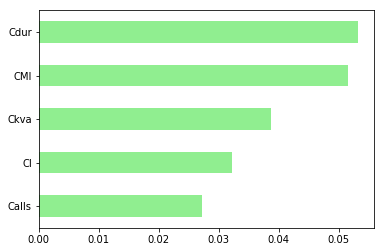

In [20]:
# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_, index = X.columns)
# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()[-5:]
# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='lightgreen')
plt.show()

# Deploy - We

In [ ]:
# Save the model as a pickle in a file 
#joblib.dump(best_model, 'We_Non_Text_RF.pkl')

# Import - WPS

In [2]:
#import data
wps_outage = pd.read_csv('WPS_Cleaned.csv')
wps_outage.head()

,State_MI,State_WI,Agency_ANT,Agency_CHI,Agency_ER,Agency_GB,Agency_KEW,Agency_MER,Agency_MIN,Agency_MM,...,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,outage category,outage subcategory
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,Equipment,Insulator
1,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,Equipment,Connector/Splice
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,Wildlife,Bird
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,Weather,Other
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,Equipment,Simple Interrupting Device


# Train - WPS

In [4]:
#split features and target
X = wps_outage.drop(['outage category', 'outage subcategory'], axis=1)
Y = pd.factorize(wps_outage['outage category'])[0]
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state=53)

In [5]:
#set up models
rf = RandomForestClassifier()
'''
#HyperParameters
params = {'n_estimators': [250, 500, 750],
          'max_features': [.5, .9],
         'min_samples_leaf': [5, 10]}
#Set up Tuning
model_cv = GridSearchCV(rf, params, cv = 3, scoring='accuracy', n_jobs=-1)
'''

"\n#HyperParameters\nparams = {'n_estimators': [250, 500, 750],\n          'max_features': [.5, .9],\n         'min_samples_leaf': [5, 10]}\n#Set up Tuning\nmodel_cv = GridSearchCV(rf, params, cv = 3, scoring='accuracy', n_jobs=-1)\n"

In [6]:
#train
model_cv = rf.fit(X_train, y_train)
#best_model = model_cv.best_model_
#best_model.best_estimator_

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# Test - WPS

In [7]:
#model performance
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.591032967032967

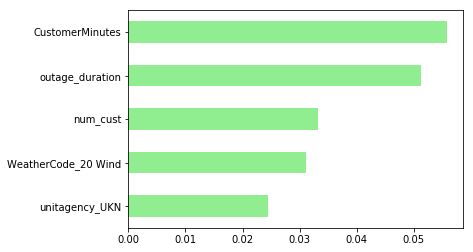

In [13]:
# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_, index = X.columns)
# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()[-5:]
# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='lightgreen')
plt.show()

unitagency_UKN         0.024478
WeatherCode_20 Wind    0.031127
num_cust               0.033207
outage_duration        0.051314
CustomerMinutes        0.055895
dtype: float64

# Deploy - WPS

In [ ]:
# Save the model as a pickle in a file 
joblib.dump(best_model, 'WPS_Non_Text_RF.pkl')